In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
        
import matplotlib as mpl
%matplotlib inline
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from PIL import Image
from IPython.display import Image as Imgdisplay

import glob
import argparse
import os

import shutil
import psutil
from pathlib import Path

from trend_labeling import seq_seq_trend
from candlechart4ML import candlechart_generator

In [2]:
def removeOutput(filepath):
    if(Path(filepath)).is_file():
        os.remove(filepath)
    
def csv_initiator(market, ticker, head_date, tail_date):
    df = fdr.DataReader(ticker, head_date, tail_date, exchange=market)
    
    filedir = os.getcwd() + '\\dataset\\raw_data\\'
    filename = "{}_{}.csv".format(market, ticker)    
    filepath = filedir + filename
    
    if not os.path.exists(filedir):
        os.makedirs(filedir)    
    removeOutput(filepath)
    df.to_csv(filepath)
    
    print("csv file saved as : {}".format(filepath))
    
    return filepath

In [3]:
# main
market = 'KRX'
ticker = '005930'
seq_len = 20
tre_len = 20
head_date = '2000-01-01'
tail_date = '2022-01-01'
dimension = 60
use_volume = False

data_csv_path = csv_initiator(market, ticker, head_date, tail_date)
label_set_path = seq_seq_trend(data_csv_path, seq_len=seq_len, tre_len=tre_len)
candlechart_dir = candlechart_generator(data_csv_path, seq_len=seq_len, tre_len=tre_len, dimension=dimension, use_volume=use_volume)

csv file saved as : C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\ML Quant Strategy\CandleChart_Binary_Classifier\candlechart_reaserch\dataset\raw_data\KRX_005930.csv
Creating label . . .
type : Sequence to Sequence
sequence_length : 20, trend_sequence_length : 20, gap : 0
Create label finished.
Converting ohlc to candlestick
Converting finished


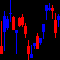

In [4]:
Imgdisplay(candlechart_dir + os.listdir(candlechart_dir)[0], height=180, width=180) # 생성된 캔들차트 샘플확인

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [6]:
# 캔들차트이미지를 데이터 셋으로
# 한 픽셀의 RGB 값, 한 변의 픽셀 수는 dimension
def image2dataarray(candlechart_dir):
    symbol = candlechart_dir.split('\\')[-3]
    imgs = list([])
    for i in range(len(os.listdir(candlechart_dir))):
        imgname = '{}-{}.png'.format(symbol, i)
        im = Image.open(candlechart_dir+imgname)
        pixels = list(im.getdata())
        img = list([])
        for pixel in pixels:
            for j in range(3): # Excepting alpha value
                img.append(pixel[j])
        imgs.append(img)
        # print(imgs)
    return np.array(imgs)

def label2dataarray(label_set_path):
    label_array = list([])
    with open(label_set_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            label = int(line.split(',')[-1])
            label_array.append(label)
        return np.array(label_array)

In [8]:
candle_array = image2dataarray(candlechart_dir)
label_array = label2dataarray(label_set_path)
print(len(candle_array), len(label_array))

5389 5389


In [9]:
X_all = candle_array
y_all = label_array

slicer = int(0.9 * len(candle_array))

X_train, y_train = X_all[:slicer], y_all[:slicer]
X_test, y_test = X_all[slicer:], y_all[slicer:]

In [10]:
# The possible options for loss are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’
# or a regression loss: ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.

my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
params = {
    'sgc__loss'    : ['hinge'],
    'sgc__penalty' : ['l1', 'l2'],
    # 'sgc__epsilon' : [-100, -10, -1],
    'sgc__alpha'   : [10, 100, 1000],
}

In [11]:
sgd_cla_pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("sgc", SGDClassifier(random_state=42))
])

sgd_cla = GridSearchCV(sgd_cla_pipe, param_grid=params, cv=my_cv, n_jobs=-1)
sgd_cla.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000025B50BB8740>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgc',
                                        SGDClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'sgc__alpha': [10, 100, 1000], 'sgc__loss': ['hinge'],
                         'sgc__penalty': ['l1', 'l2']})

In [12]:
print("best parameter :\n", sgd_cla.best_params_)
print("best prediction: {0:.4f}".for mat(sgd_cla.best_score_))
print("train set score: {0:.7f}".format(sgd_cla.score(X_train, y_train))) # 훈련세트 점수
print(" test set score: {0:.7f}".format(sgd_cla.score(X_test, y_test))) # 검증세트 점수

SyntaxError: invalid syntax (Temp/ipykernel_16092/3970894284.py, line 2)

In [ ]:
unique, counts = np.unique(sgd_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

In [ ]:
randf_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("randf", RandomForestClassifier()),
            ])
randf_cla.fit(X_train, y_train)
print("train_set score: ", randf_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", randf_cla.score(X_test, y_test)) # 검증세트 점수

In [25]:
unique, counts = np.unique(randf_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[235 304]


In [26]:
ada_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("ada", AdaBoostClassifier()),
            ])
ada_cla.fit(X_train, y_train)
print("train_set score: ", randf_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", randf_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  1.0
test_set score :  0.7402597402597403


In [27]:
unique, counts = np.unique(ada_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[235 304]


In [28]:
svm_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("svc", SVC()),
            ])
svm_cla.fit(X_train, y_train)
print("train_set score: ", svm_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", svm_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  0.9237113402061856
test_set score :  0.7291280148423006


In [29]:
unique, counts = np.unique(svm_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[243 296]
